In [1]:
import os
import sys
import itertools
import math
import json
import re
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import glob
import pickle
from collections import defaultdict
import cv2
import tqdm

#unbalanced dataset
from sklearn.utils import class_weight

#import local version of the library of Mask RCNN
sys.path.append('C:\\Users\\camil\\Desktop\\animals_code\\Mask_RCNN')
import tensorflow as tf
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images, display_top_masks

import utils_data_class_and_config

#data augmentation import local version of the library imgaug
sys.path.append('C:\\Users\\camil\\Desktop\\animals_code\\imgaug')
import imgaug as ia
from imgaug import augmenters as iaa

%matplotlib inline 

In [2]:
path_all_annotated_image = os.path.join('datasets','KBF','ANNOTATED_IMAGES')

## Configurations

In [3]:
config = utils_data_class_and_config.DataConfig()
#config.display()

## Dataset

In [4]:
subset = 'train'

In [6]:
#load data
dataset = utils_data_class_and_config.VGG_Dataset()
dataset.load_vgg(path_all_annotated_image, subset)

#must be called before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 151
Class Count: 5
  0. BG                                                
  1. F                                                 
  2. G                                                 
  3. GF                                                
  4. R                                                 


## small understanding of our data

In [7]:
#load annotations
#annotations = pickle.load(open(os.path.join(path_all_annotated_image,'annotation_'+subset+'.pkl'), 'rb'))
annotations = pickle.load(open(os.path.join(path_all_annotated_image,'annotation_'+subset+'.pkl'), 'rb')) #remove_MA = True in config 
#annotations = pickle.load(open(os.path.join(path_all_annotated_image,'annotation_algue_'+subset+'.pkl'), 'rb')) #remove_MA = False in config 

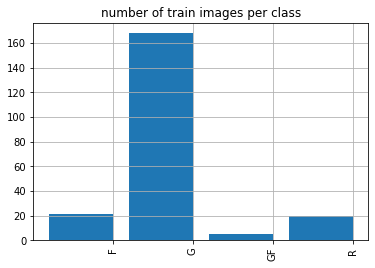

In [8]:
dico_class_filename = defaultdict(list)
for img_info in annotations:
    filename_ = img_info['filename']
    id_ = img_info['class_id_']
    for type_ in id_:
        dico_class_filename[type_].append(filename_)
        
dico_classid_id = pickle.load(open(os.path.join(path_all_annotated_image, 'algo_file','dico_classid_id.pkl'), 'rb'))

dico_id_classid = {v:k for k,v in dico_classid_id.items()}
dico_class_nbrfilename = {dico_id_classid[k]:len(v) for k,v in dico_class_filename.items()}

x = list(dico_class_nbrfilename.keys())
y = list(dico_class_nbrfilename.values())
fig = plt.figure()
ax = plt.subplot(111)
width=0.8
ax.bar(range(len(x)), y, width=width)
ax.set_xticks(np.arange(len(x)) + width/2)
ax.set_xticklabels(x, rotation=90);
plt.grid()
plt.title('number of train images per class');

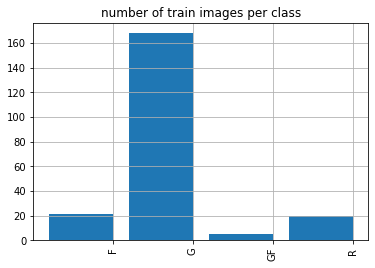

In [9]:
dico_class_filename = defaultdict(list)
for img_info in annotations:
    filename_ = img_info['filename']
    id_ = img_info['class_id_']
    for type_ in id_:
        dico_class_filename[type_].append(filename_)
        
dico_class_nbrfilename = {dico_id_classid[k]:len(v) for k,v in dico_class_filename.items()}

x = list(dico_class_nbrfilename.keys())
y = list(dico_class_nbrfilename.values())
fig = plt.figure()
ax = plt.subplot(111)
width=0.8
ax.bar(range(len(x)), y, width=width)
ax.set_xticks(np.arange(len(x)) + width/2)
ax.set_xticklabels(x, rotation=90);
plt.grid()
plt.title('number of train images per class');

In [10]:
dico_class_nbrfilename

{'F': 21, 'G': 168, 'GF': 5, 'R': 20}

## Verifying data augmentation on masks

In [11]:
MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes","Fliplr", "Flipud", "CropAndPad","Affine", "PiecewiseAffine"]

def hook(images, augmenter, parents, default):
    """Determines which augmenters to apply to masks."""
    return augmenter.__class__.__name__ in MASK_AUGMENTERS

In [12]:
len(dataset.image_ids)

151

In [13]:
aug = iaa.Sometimes(0.75,[
        
    #Sharpen or emboss an image: 'see more the pixels' & contrast
    iaa.SomeOf(0.4,[iaa.Sharpen(alpha=(0.5,1), lightness=(1)),
                  iaa.Emboss(alpha=(0.5,1), strength=(1.0,1.7)),
                   iaa.ContrastNormalization((0.5,1.5))]),
    
    #dangerous with our data
    #Add r values between -30 and 30 to images. In 50% of all images the values differ per channel (3 sampled value). 
    #In the other 50% of all images the value is the same for all channels: (change color constancy)
    #iaa.Add((-20, 20), per_channel=0.5),
    #Increase/decrease S (saturation i.e. how colorful it is)
    #iaa.WithColorspace(to_colorspace="HSV", from_colorspace="RGB", 
    #                         children=iaa.WithChannels(1, iaa.Multiply((0.65,1.35)))),
    #not good as it can be part of caracteristic for species
    #scale image independantly in x and y axis 
    #iaa.Affine(scale={"x": (0.75, 1.25), "y": (0.75, 1.25)}),
    #distortion
    #iaa.PiecewiseAffine(scale=(0.01, 0.03)),
    
    #darkness/brightness choose one of both technique
    iaa.SomeOf(1,[iaa.Multiply((0.75, 1.25)),
                  #Increase/decrease V (value i.e. how bright/dark) 
                  iaa.WithColorspace(to_colorspace="HSV", from_colorspace="RGB", 
                                         children=iaa.WithChannels(2, iaa.Multiply((0.75, 1.25))))]),
    
    #flip horizontaly and vertically to make as if the fish was swimimg from both direction and from upside down
    iaa.Fliplr(0.5),
    iaa.Flipud(0.2),
    iaa.Sometimes(0.3,iaa.Affine(rotate=(-75, 75))),
    #iaa.Sometimes(0.5,iaa.SomeOf(1, [iaa.Affine(rotate=15),iaa.Affine(rotate=30),iaa.Affine(rotate=45),
    #                                 iaa.Affine(rotate=5),iaa.Affine(rotate=10),iaa.Affine(rotate=25),
    #                                 iaa.Affine(rotate=60),iaa.Affine(rotate=75),iaa.Affine(rotate=0)]))
    
    #weather: Clouds, Fog, Snowflakes & noise #iaa.Fog(),iaa.Snowflakes(density=(0.005, 0.025),flake_size=(0.2, 1.0))
    #noise: 
    iaa.Sometimes(0.2,iaa.AdditiveGaussianNoise(scale=0.007*255))
    #AttributeError: 'CloudLayer' object has no attribute 'density_min'
    #iaa.Sometimes(0.2,[iaa.SomeOf(1,[iaa.Clouds(),
    #                                 iaa.Snowflakes(density=(0.005, 0.025),flake_size=(0.2, 1.0))])]),
])

-------------------------------- 95
112.jpg 95


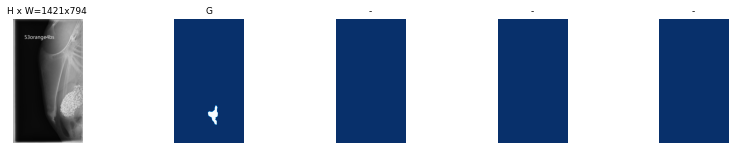

-------------------------------- 23
30.jpg 23


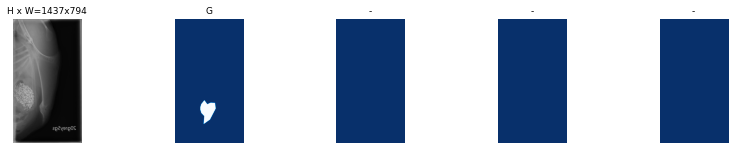

-------------------------------- 128
150.jpg 128


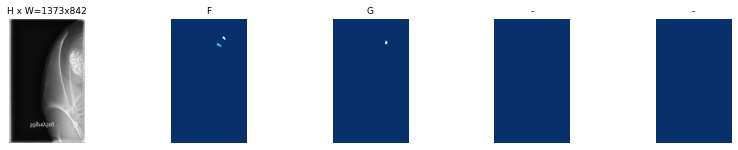

-------------------------------- 105
123.jpg 105


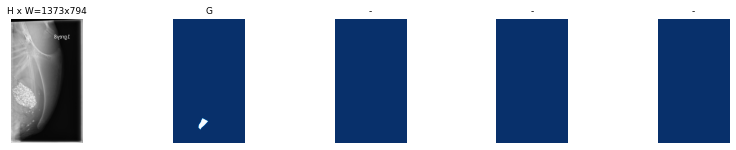

-------------------------------- 31
38.jpg 31


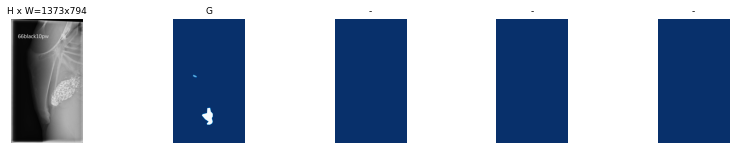

-------------------------------- 52
62.jpg 52


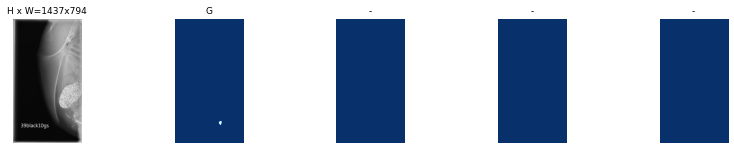

-------------------------------- 2
2.jpg 2


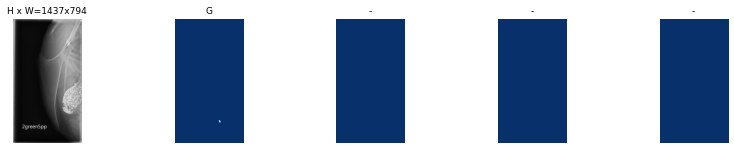

-------------------------------- 67
79.jpg 67


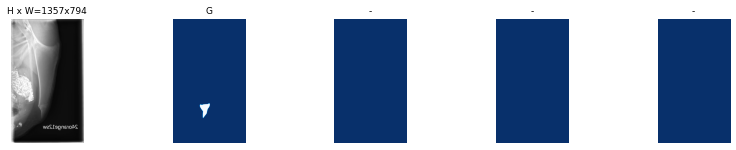

-------------------------------- 93
110.jpg 93


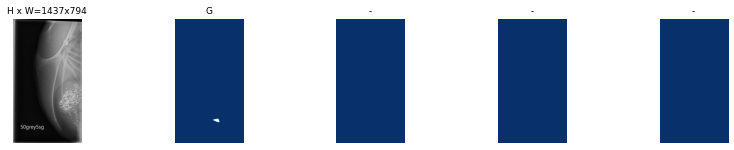

-------------------------------- 98
115.jpg 98


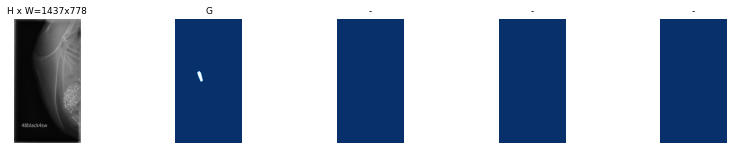

In [14]:
#show A random sample
image_ids = np.random.choice(dataset.image_ids, 10) #len(dataset.image_ids))
for image_id in image_ids:
    
    print('--------------------------------', image_id)
    #load data
    image = dataset.load_image(image_id)
    filename_ = dataset.load_filename(image_id) 
    mask, class_ids = dataset.load_mask(image_id)

    #augment
    det = aug.to_deterministic()    
    image = det.augment_image(image)
    # Change mask to np.uint8 because imgaug doesn't support np.bool
    mask = det.augment_image(mask.astype(np.uint8),hooks=ia.HooksImages(activator=hook))
    print(filename_, image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)